# <p style='text-align: center;'><font color='#474747'>PROJECT-3. Решение комплексной бизнес-задачи</font></p>
## <font color='#00b43f'>ЗАДАЧИ:</font> 
1. **Построить рекомендательную систему**, благодаря которой можно будет предлагать клиентам интересные им курсы. Для этого потребуется подготовить и проанализировать имеющиеся данные.
2. **Составить итоговую таблицу с рекомендациями**, снабдив её необходимыми комментариями, и представить  продакт-менеджеру.
3. **Проанализировать результаты А/Б-теста**, проведённого после внедрения фичи, **сделать вывод**.

***Приступим к первой задаче***

In [1]:
# Импорты нужных библиотек и функций
import pandas as pd
import numpy as np 
import seaborn as sns 
from collections import Counter 
import matplotlib.pyplot as plt
from scipy.stats import norm 
from scipy.stats import beta 
from scipy.stats import t 
import psycopg2
import psycopg2.extras 

### ГОТОВИМ ДАННЫЕ ДЛЯ АНАЛИЗА
Для построения рекомендательной системы решил определить, какие другие курсы чаще всего покупаются вместе с конкретным курсом (необязательно в рамках одной корзины).  
Так смогу ранжировать все курсы и взять только те, что с наибольшей вероятностью заинтересуют клиентов.  
На этом этапе нужно подготовить данные для анализа: написать SQL-запрос, который выгружает данные по всем продажам курсов в разрезе пользователей.  
*Выполним запрос, после которого выгрузим данные в датафрейм*

In [2]:
def getUsersCount(): # Конструкция pd.DataFrame(getUsersCount()) позволяет выполнить функцию запроса, а затем записать полученные данные в датафрейм
    query = '''WITH user_count_buy AS 
(--количество клиентов купивших курсы
 SELECT count(distinct(FCarts.user_id)) AS Users 
 FROM final.Carts AS FCarts 
        INNER JOIN final.cart_items AS FCI  
            ON FCarts.id = FCI.cart_id 
        WHERE FCarts.state = 'successful' AND 
                                            FCI.resource_type = 'Course'
), 
course_count AS 
(--количество различных курсов 
 SELECT count(distinct(FCI.resource_id)) AS c_cours 
 FROM final.cart_items AS FCI 
 WHERE FCI.resource_type = 'Course'
), 
avg_count AS 
(--среднее число купленных курсов на одного клиента
 SELECT sum(count_res)*1.0/count(user_id) 
 FROM (
    SELECT FCarts.user_id, count(FCI.resource_type) AS count_res  
    FROM final.Carts AS FCarts 
            INNER JOIN final.cart_items AS FCI 
                ON FCarts.id = FCI.cart_id 
                WHERE FCarts.state = 'successful' AND 
                                                      FCI.resource_type = 'Course' 
                GROUP BY FCarts.user_id) AS alias01
), 
count_users_many AS 
(--Сколько клиентов купили больше одного курса
 SELECT count(user_id) 
 FROM (
        SELECT FCarts.user_id, count(FCI.resource_type) AS count_res  
        FROM final.Carts AS FCarts 
            INNER JOIN final.cart_items AS FCI 
                ON FCarts.id = FCI.cart_id 
        WHERE FCarts.state = 'successful' AND 
                                            FCI.resource_type = 'Course' 
        GROUP BY FCarts.user_id 
        HAVING count(distinct(FCI.resource_id))>1) AS alias01
), 
count_users AS 
(
 SELECT user_id, count_res 
 FROM (
        SELECT FCarts.user_id, count(FCI.resource_type) AS count_res  
        FROM final.Carts AS FCarts 
            INNER JOIN final.cart_items AS FCI 
                ON FCarts.id = FCI.cart_id 
        WHERE FCarts.state = 'successful' AND 
                                            FCI.resource_type = 'Course' 
        GROUP BY FCarts.user_id 
        HAVING count(distinct(FCI.resource_id))>1) AS alias02
) 
SELECT FCarts.user_id, FCI.resource_id, count_users.count_res --таблица для анализа с помощью Python
FROM count_users 
    INNER JOIN final.Carts AS FCarts 
        USING(user_id) 
    INNER JOIN final.cart_items AS FCI 
        ON FCarts.id = FCI.cart_id 
        WHERE FCarts.state = 'successful' AND 
                                            FCI.resource_type = 'Course' 
ORDER BY 1;'''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

users_count_buy = pd.DataFrame(getUsersCount())

**ОБРАБАТЫВАЕМ ДАННЫЕ**  
Итак, получил файл с данными по продажам курсов в разрезе пользователей (по купившим больше одного курса).  
Перехожу к его анализу с помощью Python.  
Необходимо разбить все покупки курсов на пары, после чего ранжировать их для каждого курса.

In [3]:
users_count_buy.info() # Получим информацию о датафрейме (сразу смотрим на наличие пропусков)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34172 entries, 0 to 34171
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      34172 non-null  int64
 1   resource_id  34172 non-null  int64
 2   count_res    34172 non-null  int64
dtypes: int64(3)
memory usage: 801.0 KB


In [4]:
users_count_buy # Посмотрим на получившийся датафрейм

,user_id,resource_id,count_res
0,51,1099,2
1,51,516,2
2,6117,356,3
3,6117,1125,3
4,6117,357,3
...,...,...,...
34167,2188926,743,2
34168,2188926,515,2
34169,2190141,794,3
34170,2190141,1185,3


In [5]:
users_count_buy = users_count_buy.drop_duplicates() # Удалим дубликаты

In [6]:
users_count_buy # Посмотрим результат

,user_id,resource_id,count_res
0,51,1099,2
1,51,516,2
2,6117,356,3
3,6117,1125,3
4,6117,357,3
...,...,...,...
34167,2188926,743,2
34168,2188926,515,2
34169,2190141,794,3
34170,2190141,1185,3


In [7]:
# Сгруппируем пользователей и создадим колонку со списками курсов
users_buy_list = users_count_buy.groupby(['user_id'])['resource_id'].apply(lambda s: list(np.unique(s))).reset_index() 
users_buy_list

,user_id,resource_id
0,51,"[516, 1099]"
1,6117,"[356, 357, 1125]"
2,10275,"[553, 1147]"
3,10457,"[361, 1138]"
4,17166,"[356, 357]"
...,...,...
12651,2179430,"[566, 750]"
12652,2186581,"[794, 864, 1129]"
12653,2187601,"[356, 553, 571, 765, 912]"
12654,2188926,"[515, 743]"


In [8]:
import itertools # Импортируем необходимую библиотеку
courses_couple = [] # Создаём пустой список
for resource in users_buy_list['resource_id']: # пройдем по спискам курсов
    for couple in itertools.combinations(sorted(list(resource)), 2): # списки отсортируем и разделим на пары
        courses_couple.append(couple) # запишем получившиеся кортежи в список 
len(courses_couple) # Количество получившихся пар

40017

In [94]:
courses_couple_counter = Counter(courses_couple) # Создадим словарь с количеством повторений пар курсов
# Отсортируем словарь по значению по убыванию (наиболее популярные пары курсов будут наверху, а внизу - наименее популярные)
courses_counter_sorted = {} # Создадим пустой словарь, в который потом запишем кортежи ключей со значениями
sorted_keys = sorted(courses_couple_counter, key=courses_couple_counter.get, reverse=True) # Отсортируем по убыванию
for i in sorted_keys: 
    courses_counter_sorted[i] = courses_couple_counter[i] # Значениями будут количество повторений пар
display(courses_counter_sorted) # Выведем на экран

{(551, 566): 797,
 (515, 551): 417,
 (489, 551): 311,
 (523, 551): 304,
 (566, 794): 290,
 (489, 515): 286,
 (490, 566): 253,
 (490, 551): 247,
 (570, 752): 247,
 (569, 572): 216,
 (515, 523): 213,
 (553, 745): 212,
 (489, 523): 206,
 (569, 840): 204,
 (514, 551): 200,
 (516, 745): 199,
 (515, 566): 195,
 (489, 566): 188,
 (504, 572): 184,
 (572, 840): 178,
 (551, 552): 177,
 (507, 570): 172,
 (490, 809): 163,
 (489, 490): 152,
 (507, 752): 150,
 (523, 552): 144,
 (490, 515): 143,
 (551, 570): 142,
 (504, 569): 139,
 (514, 515): 139,
 (551, 745): 138,
 (514, 566): 138,
 (502, 551): 135,
 (504, 840): 135,
 (571, 1125): 122,
 (502, 566): 120,
 (523, 566): 120,
 (570, 809): 119,
 (752, 809): 115,
 (490, 523): 114,
 (357, 571): 112,
 (523, 564): 110,
 (551, 749): 109,
 (516, 553): 107,
 (551, 777): 107,
 (551, 679): 104,
 (356, 571): 103,
 (551, 564): 103,
 (515, 749): 103,
 (568, 745): 102,
 (356, 357): 100,
 (363, 511): 99,
 (551, 571): 98,
 (551, 809): 96,
 (502, 514): 95,
 (551, 794): 

In [10]:
len(courses_counter_sorted) # Сколько различных пар курсов встречаются вместе в покупках клиентов?

3989

***Приступим ко второй задаче***  
**Теперь оформим таблицу с рекомендациями для продакт-менеджера и отдела маркетинга.**  
Составим таблицу с тремя столбцами:  
Курс, к которому идёт рекомендация.  
Курс для рекомендации № 1 (самый популярный).  
Курс для рекомендации № 2 (второй по популярности).  
<font color='#FF6347'>***Курсы, у которых не будет получено рекомендаций - в рекомендацию № 1 добавлю первый по популярности курс, а в рекомендацию № 2 - второй по популярности курс!***</font> 

In [11]:
advice = [] # Создадим пустые списки
advice1,advice2,advice3 = [],[],[] 
for key in courses_counter_sorted.keys(): # Добавим в первый список первый ключ кортежа, во второй - второй ключ
    advice1.append(key[0]) 
    advice2.append(key[1]) 
for j in range(len(advice1)): # Переберем значения первого и второго списков, добавляя в третий id курсов для рекомендации № 2
    if (advice1[j] in advice2) and (advice1[j] in advice1[j+1:]): # если id есть в первом и втором списке - тогда выбираем id, который выше
        if j+1+advice1[j+1:].index(advice1[j])<advice2.index(advice1[j]): 
            advice3.append(advice2[j+1+advice1[j+1:].index(advice1[j])]) 
        elif j+1+advice1[j+1:].index(advice1[j])>advice2.index(advice1[j]): 
            advice3.append(advice1[advice2.index(advice1[j])]) 
    if (advice1[j] not in advice2) and (advice1[j] in advice1[j+1:]): # если id есть только в первом списке - добавляем его соседа из второго списка
        advice3.append(advice2[j+1+advice1[j+1:].index(advice1[j])]) 
    if (advice1[j] in advice2) and (advice1[j] not in advice1[j+1:]): # если id есть только во втором списке - добавляем его соседа из первого списка
        advice3.append(advice1[advice2.index(advice1[j])]) 
for nan in range(len(advice3),len(advice1)): # Заменим на пустые значения, чтобы получить третий список такой же длины как другие два
    advice3.append(np.nan)
recomend=pd.DataFrame(advice1) # Создадим датафрейм и добавим в него колонки с первым. вторым и третьим списком
recomend['1']=advice2 # Добавим столбцы с курсами второго и третьего списка
recomend['2']=advice3 
recomend # Посмотрим на результат

,0,1,2
0,551,566,515.0
1,515,551,489.0
2,489,551,515.0
3,523,551,515.0
4,566,794,551.0
...,...,...,...
3984,741,791,551.0
3985,361,1128,566.0
3986,743,1156,NaN
3987,864,1129,NaN


In [12]:
for i in range(len(advice1)): # Посмотрим, есть ли номера id во втором столбце, которых нет в первом столбце
    if advice2[i] not in advice1: 
        if advice2[i] not in advice: 
            advice.append(advice2[i]) # Добавим их в отдельный список
print(advice) # Выведем на экран список id курсов, которых нет в первом столбце

[1184, 1188, 1198, 1160, 1199, 833, 1201, 902, 1200]


In [13]:
for index, row in recomend.iterrows(): # Добавим в датафрейм строки, начинающиеся с id, которых нет в первом столбце
    if row['1'] in advice: 
        recomend.loc[len(recomend)]=[row['1'], row[0], row['2']] 
recomend # Посмотрим на результат

,0,1,2
0,551.0,566.0,515.0
1,515.0,551.0,489.0
2,489.0,551.0,515.0
3,523.0,551.0,515.0
4,566.0,794.0,551.0
...,...,...,...
4124,1188.0,836.0,1100.0
4125,1188.0,1101.0,490.0
4126,1188.0,1102.0,490.0
4127,902.0,742.0,490.0


In [14]:
recomend=recomend.drop_duplicates(subset=[0],ignore_index=True) # Удалим дубликаты по первому столбцу
recomend # Посмотрим на результат

,0,1,2
0,551.0,566.0,515.0
1,515.0,551.0,489.0
2,489.0,551.0,515.0
3,523.0,551.0,515.0
4,566.0,794.0,551.0
...,...,...,...
121,1199.0,523.0,515.0
122,833.0,507.0,489.0
123,1201.0,571.0,357.0
124,902.0,519.0,489.0


In [15]:
# Посмотрим, есть ли во втором и третьем столбце одинаковые значения, чтобы не давать одинаковых рекомендаций
for index, row in recomend.iterrows(): 
    if row['1']==row['2']: 
        print(index, row) # Таких строк нет

In [16]:
recomend = recomend.astype({0: 'Int64','1': 'Int64','2': 'Int64'}) # Приведем тип данных к целому числу 
recomend # Выведем на экран

,0,1,2
0,551,566,515
1,515,551,489
2,489,551,515
3,523,551,515
4,566,794,551
...,...,...,...
121,1199,523,515
122,833,507,489
123,1201,571,357
124,902,519,489


Выполним запрос к исходным данным для получения списка всех курсов

In [17]:
def getUsersCount1(): # Конструкция pd.DataFrame(getUsersCount1()) позволяет выполнить функцию запроса, а затем записать полученные данные в датафрейм
    query = '''SELECT distinct(FCI.resource_id) AS c_cours 
 FROM final.cart_items AS FCI 
 WHERE FCI.resource_type = 'Course' 
 ORDER BY 1;'''.format() # Подключение к существующей базе данных
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor) # Откройте курсор для выполнения операций с базой данных
    dict_cur.execute(query) # Выполните команду: это создаст новую таблицу
    rows = dict_cur.fetchall() # Запишем в rows записи в виде упорядоченного списка
    data = [] # Создадим пустой список
    for row in rows:
        data.append(dict(row)) # В пустой список добавим выгруженный словарь
    return data 
users_resource_id = pd.DataFrame(getUsersCount1()) # Создадим датафрейм с id курсов отсортировав их

In [18]:
users_resource_id # Посмотрим что получилось

,c_cours
0,356
1,357
2,358
3,359
4,360
...,...
122,1188
123,1198
124,1199
125,1200


После получения списка курсов обьединим их с полученной таблицей рекомендаций

In [19]:
users_resource_id.rename(columns={'c_cours': 0}, inplace = True) # Переименуем столбец 
recommendation = users_resource_id.merge(recomend, on = 0, how = 'left') # Обьединим по первому столбцу
recommendation # Посмотрим на результат

,0,1,2
0,356,571,357
1,357,571,356
2,358,570,752
3,359,570,358
4,360,745,516
...,...,...,...
122,1188,1141,513
123,1198,571,357
124,1199,523,515
125,1200,866,865


In [20]:
np.where(pd.isnull(recommendation)) # Посмотрим, есть ли пустые значения (получилось одно пустое значение - курс, который никто не покупал)

(array([62, 62], dtype=int64), array([1, 2], dtype=int64))

In [21]:
recommendation['1'].fillna(551, inplace = True) # Заменим пустые значения во втором столбце на самый популярный курс
recommendation['2'].fillna(566, inplace = True) # Заменим в третьем столбце на второй по популярности курс

## Получим итоговую таблицу с рекомендациями

In [22]:
# Переименуем столбцы
recommendation.rename(columns={0:'Курс', '1':'Курс для рекомендации № 1', '2':'Курс для рекомендации № 2'}, inplace = True) 
recommendation # Посмотрим на результат

,Курс,Курс для рекомендации № 1,Курс для рекомендации № 2
0,356,571,357
1,357,571,356
2,358,570,752
3,359,570,358
4,360,745,516
...,...,...,...
122,1188,1141,513
123,1198,571,357
124,1199,523,515
125,1200,866,865


In [88]:
# Набор CSS свойств элементов th в фрейме данных
th_props = [
  ('font-size', '14px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#000000'),
  ('background-color', '#f7f7f9')
  ] 
# Набор CSS свойства элементов td в фрейме данных
td_props = [
  ('font-size', '14px'), 
  ('text-align', 'center')
  ] 
# Набор табличных стилей
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ] 
# Напишем функцию по изменению цвета текста
def color(s): 
    df = s.copy() 
    df.loc[:, :] = 'color: %s' % 'green' 
    df[['Курс для рекомендации № 1']] = 'color: %s' % 'red' 
    df[['Курс для рекомендации № 2']] = 'color: %s' % 'navy' 
    return df 

## <font color='#0000CC'>Вывод по первой и второй задаче:</font>  
Итак, я построил рекомендательную систему, составил ***итоговую таблицу с рекомендациями*** сохранил её в формате Excel.  
В первой колонке - id курса, во второй - id курса для первой рекомендации, в третьей - id курса для второй рекомендации! 

In [89]:
recommendation.style.apply(color, axis = None).set_table_styles(styles) # Применим стили к таблице

,Курс,Курс для рекомендации № 1,Курс для рекомендации № 2
0,356,571,357
1,357,571,356
2,358,570,752
3,359,570,358
4,360,745,516
5,361,551,1138
6,362,363,562
7,363,511,562
8,364,551,503
9,365,551,566


In [92]:
recommendation.to_csv('recommendation.csv') # Сохраним полученную таблицу с рекомендациями в формате csv 
# и сохраним в формате xlsx с сохранением стиля
recommendation.style.apply(color, axis = None).set_table_styles(styles).to_excel('recommendation.xlsx', index=False, engine='openpyxl') 

***Приступим к третьей задаче***  
Хороший аналитик не может просто взять, отдать табличку с рекомендациями и спать спокойно. Хороший аналитик после внедрения предложенной системы обязательно включится в работу по тестированию гипотезы. 

## Запускаем А/Б тест 
Итак, спустя месяц на сайте реализована новая функциональность с предложением добавить в корзину второй подходящий курс. Ваши коллеги хотят оценить эффективность этой функции и качество подбора рекомендаций.  
Для этого запускается сплит-тест, где все клиенты случайным образом делятся на <font color='#00b43f'>**контрольную**</font> и <font color='#00b43f'>**тестовую**</font> группы. Тестовой группе показываются рекомендации, а контрольной — нет.  
До реализации рекомендаций средняя конверсия в покупку второго курса была **3,2%**. Вы ожидаете, что ввод рекомендаций сможет поднять её до **4%**.

In [247]:
# Определите минимальный размер выборки для проведения теста при уровне достоверности 95% и статистической мощности 80%
Z=-norm.ppf((1-0.95)/2) # коэффициент, зависящий от выбранного исследователем доверительного уровня
p=0.8 # доля респондентов с наличием исследуемого признака
q=1-p # доля респондентов, у которых исследуемый признак отсутствует
A=0.008855 # предельная ошибка выборки (для принятия бизнес-решений ошибка выборки должна быть не больше 4%)
n=(Z**2*p*q)/(A**2) 
print(n) # минимальный объем выборки

7838.6095744961885


Что ж, прошло три недели. Каждый из вариантов сплит-теста достиг необходимого размера выборки, и вам необходимо принять решение, был ли ввод рекомендаций успешен.
Вот результаты:
1. В <font color='#00b43f'>**контрольной группе**</font> оказалось 8732 клиента, оформивших заказ, из них 293 купили больше одного курса.
2. В <font color='#00b43f'>**тестовой**</font> — 8847 клиентов, из них 347 купили больше одного курса.

In [95]:
# Чему равно p-значение?
p_value=1-norm.cdf((347/8847-293/8732)/(640/(8847+8732)*(1-640/(8847+8732))*(1/8732+1/8847))**(0.5)) 
print(round(p_value,3)) # значение p-value, округлив до 3 знаков 

0.022


In [5]:
# Содержание импортируемого модуля calc_prob.py:
from math import lgamma
from numba import jit

#defining the functions used
@jit
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

@jit
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1]) 

In [21]:
# Известные данные контрольной и тестовой групп: показы и конверсии контрольной и тестовой групп
imps_ctrl,convs_ctrl=8732, 293 
imps_test,convs_test=8847, 347 

# здесь мы создаем бета-функции для двух наборов
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
beta_C = beta(a_C, b_C)
a_T, b_T = convs_test+1, imps_test-convs_test+1
beta_T = beta(a_T, b_T)

# расчёт подъёма
lift=(beta_T.mean()-beta_C.mean())/beta_C.mean()

# вычисление вероятности того, что тест будет лучше, чем контроль
prob=calc_prob_between(beta_T, beta_C)

print (f'Тестовый вариант повышения коэффициентов конверсии на {lift*100:2.2f}% лучше с {prob*100:2.1f}% вероятностью.') 

Тестовый вариант повышения коэффициентов конверсии на 16.83% лучше с 97.8% вероятностью.


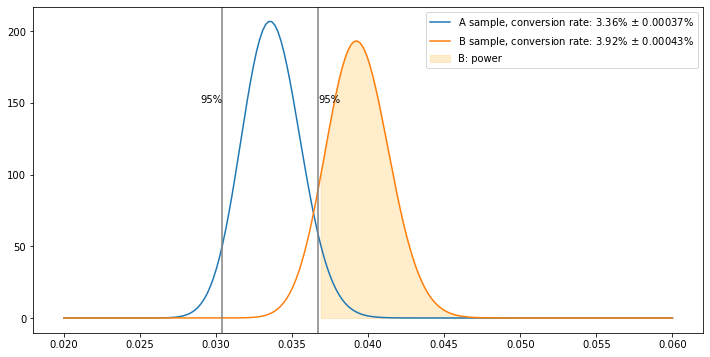

In [88]:
def calc_beta_mode(a, b):
    '''эта функция вычисляет режим (пик) бета-распределения'''
    return (a-1)/(a+b-2)

p1,p2=convs_ctrl/imps_ctrl,convs_test/imps_test 
p=(convs_ctrl+convs_test)/(imps_ctrl+imps_test) 
z=(p2-p1)/((p*(1-p)*((1/imps_ctrl)+(1/imps_test)))**0.5) 
p_value=1-norm.cdf(z)

def plot(betas, names, linf=0.02, lsup=0.06):
    '''эта функция строит бета-распределение'''
    x=np.linspace(linf,lsup, 200)
    for f, name in zip(betas,names) :
        y=f.pdf(x) # это для вычисления значения для PDF в указанных точках x
        y_mode=calc_beta_mode(f.args[0], f.args[1])
        y_var=f.var() # дисперсия бета-распределения
        plt.plot(x,y, label=f'{name} sample, conversion rate: {y_mode*100:2.2f}% $\pm$ {y_var*100:2.2}%') 
    plt.axvline(p1+t.ppf(0.05/2,imps_ctrl-1)*p_value**0.5/(imps_ctrl**0.5), color='grey') 
    plt.axvline(p1-t.ppf(0.05/2,imps_ctrl-1)*p_value**0.5/(imps_ctrl**0.5), color='grey') 
    plt.fill_between(x[x >= p1-t.ppf(0.05/2,imps_ctrl-1)*p_value**0.5/(imps_ctrl**0.5)], 
                y[x >= p1-t.ppf(0.05/2,imps_ctrl-1)*p_value**0.5/(imps_ctrl**0.5)], 
                color='orange', alpha=0.2, label='B: power') 
    plt.annotate('95%', xy=(0.029,150)) 
    plt.annotate('95%', xy=(0.0367,150)) 
    plt.legend()
    plt.show()
plt.rcParams["figure.figsize"] = (12,6) 
plot([beta_C, beta_T], names=["A", "B"]) 

## <font color='#0000CC'>Вывод по результатам А/Б теста:</font> 
Наблюдаемый коэффициент конверсии вариации В (*3.92%*) был на **16,83%** выше, чем коэффициент конверсии вариации А (*3.36%*). Вы можете быть 95% уверены, что этот результат является следствием внесенных вами изменений, а не результатом случайной случайности.  
**Вариант с рекомендациями показал статистически значимо лучший результат, нужно реализовывать его для всех клиентов.**